# Описание проекта: Промышленность

Чтобы оптимизировать производственные расходы,\
 металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали.\
Для этого комбинату нужно контролировать температуру сплава. \
Ваша задача — построить модель, которая будет её предсказывать. \
Заказчик хочет использовать разработанную модель для имитации технологического процесса. \
Изучите его, прежде чем генерировать новые признаки.


## Описание процесса обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн.\
Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом.\
Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами.\
Они установлены на крышке ковша.

Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей.\
Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.

Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру.\
Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. \
Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.


Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. \
Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных


Данные хранятся в `Sqlite` — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:

- `steel.data_arc` — данные об электродах;
- `steel.data_bulk` — данные об объёме сыпучих материалов;
- `steel.data_bulk_time` — данные о времени подачи сыпучих материалов;
- `steel.data_gas` — данные о продувке сплава газом;
- `steel.data_temp` — данные об измерениях температуры;
- `steel.data_wire` — данные об объёме проволочных материалов;
- `steel.data_wire_time` — данные о времени подачи проволочных материалов.

### Таблица `steel.data_arc`

- `key` — номер партии;
- `BeginHeat` — время начала нагрева;
- `EndHeat` — время окончания нагрева;
- `ActivePower` — значение активной мощности;
- `ReactivePower` — значение реактивной мощности.

### Таблица `steel.data_bulk`

- `key` — номер партии;
- `Bulk1` … `Bulk15` — объём подаваемого материала.

### Таблица `steel.data_bulk_time`

- `key` — номер партии;
- `Bulk1` … `Bulk15` — время подачи материала.

#### Таблица `steel.data_gas`

- `key` — номер партии;
- `gas` — объём подаваемого газа.

#### Таблица `steel.data_temp`

- `key` — номер партии;
- `MesaureTime` — время замера;
- `Temperature` — значение температуры.

#### Таблица `steel.data_wire`

- `key` — номер партии;
- `Wire1` … `Wire9` — объём подаваемых проволочных материалов.

#### Таблица `steel.data_wire_time`

- `key` — номер партии;
- `Wire1` … `Wire9` — время подачи проволочных материалов.

Во всех файлах столбец `key` содержит номер партии. В таблицах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.


## План проекта: Прогнозирование температуры стали

### **Шаг 1. Загрузка данных**

1. Подключение к базе данных в SQLite.
2. Загрузка данных из базы данных.
3. Установка константы RANDOM_STATE. Значение равно дате начала проекта (например, RANDOM_STATE = 10922 для 1 сентября 2022 года).

### **Шаг 2. Исследовательский анализ и предобработка данных**

Общие задачи:
1. Проверка всех таблиц на наличие данных и соответствие количеству таблиц условию задачи.

**Анализ таблицы steel.data_arc:**

1. Проведение исследовательского анализа данных (EDA):
    - Проверка наличия пропусков и аномалий.
    - Изучение распределения признаков.
2. Обработка аномалий:
    - Удаление партий с аномальными значениями или замена аномальных значений.
3. Генерация новых признаков:
    - Длительность нагрева.
    - Общая мощность.
    - Соотношение активной мощности к реактивной.
    - Количество запусков нагрева электродами.
4. Агрегация наблюдений по ключу после генерации новых признаков.

**Анализ таблицы steel.data_bulk:**
1. Проведение EDA:
    - Проверка наличия пропусков и аномалий.
    - Изучение распределения признаков.
2. Обработка пропусков:
    - Пропуск означает, что материал не добавляли в партию.

**Анализ таблицы steel.data_bulk_time:**
1. Проведение EDA:
    - Проверка наличия пропусков и аномалий.
    - Изучение распределения признаков.
2. Проверка данных на адекватность (например, что подача материала не измеряется сутками).

**Анализ таблицы steel.data_gas:**
1. Проведение EDA:
    - Проверка наличия пропусков и аномалий.
    - Изучение распределения признаков.

**Анализ таблицы steel.data_temp:**
1. Проведение EDA:
    - Проверка наличия пропусков и аномалий.
    - Изучение распределения признаков.
2. Целевой признак:
    - Последняя температура партии.
3. Использование начальной температуры партии как входного признака.
4. Исключение промежуточных значений температуры для предотвращения утечки целевого признака.
5. Агрегация наблюдений:
    - Учитываются только ключи с как минимум двумя наблюдениями: первый и последний замеры температуры.
6. Обработка аномальных значений:
    - Температуры ниже 1500 градусов считаются аномальными.

**Анализ таблицы steel.data_wire:**
1. Обработка пропусков:
    - Пропуск означает, что материал не добавляли в партию.

**Анализ таблицы steel.data_wire_time:**
1. Проведение EDA:
    - Проверка наличия пропусков и аномалий.
    - Изучение распределения признаков.
2. Проверка данных на адекватность (например, что подача материала не измеряется сутками).

**Объединение таблиц по ключу:**
1. Каждой партии должно соответствовать одно наблюдение.
2. Учет всех материалов (сыпучие, проволочные) и процессов (продувка газом, нагревание).
3. Обработка возможной асинхронности времени между датчиками.

**Общий анализ объединенной таблицы:**
1. Проведение EDA объединенной таблицы.
2. Визуализация распределения каждого признака.
3. Корреляционный анализ.

**Подготовка данных для обучения:**
1. Выбор признаков для обучения.
2. Разделение данных на тренировочную и тестовую выборки (`test_size = 0.25`).
3. Подготовка данных для обучения с учетом особенностей выбранных моделей.

### **Шаг 3. Обучение модели**

1. **Рассмотрение классов моделей:**
    - Решающее дерево или случайный лес.
    - Бустинги.
    - Нейронные сети.
2. Обучение моделей и оценка их качества с использованием метрики MAE.
3. Выбор лучшей модели на основе значений метрики на кросс-валидации.
4. Подбор значений гиперпараметров:
    - Использование методов автоматизированного подбора гиперпараметров (`GridSearchCV`, `RandomizedSearchCV`, `OptunaSearchCV`, `Optuna` и другие)



### Шаг 4. Тестирование модели и демонстрация работы

1. Проверка качества лучшей модели на тестовой выборке.
2. Значение метрики MAE должно быть менее 6.8.
3. Дополнительная оценка модели с использованием R².
4. Сравнение результатов лучшей модели и константной модели.
5. Анализ важности основных признаков.
6. Проведение дополнительного исследования для одного из важных признаков:
    - Построение графика зависимости входного и целевого признаков.


### Шаг 5. Общий вывод

1. Написание общих выводов по проекту.
2. Предложение способов для дальнейшего улучшения модели.
3. Формулирование бизнес-рекомендаций заказчику.

## Подготовка данных

### Загрузка библиотек

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine, Column, Integer, String, Float, DateTime, text, select
from sqlalchemy.orm import DeclarativeBase, Session
from sqlalchemy.schema import DropTable
from sqlalchemy.ext.compiler import compiles
from sqlalchemy import MetaData, Table

from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

### Инциализация констант, настройка окружения

In [2]:
# При с работе с проектом необходимо отредактировать константу пути
PATH_TO_DATABASE = 'datasets/ds-plus-final.db'
RANDOM_STATE = 150824
# Создаем объект подключения (engine) к базе данных SQLite
engine = create_engine(f'sqlite:///{PATH_TO_DATABASE}', echo=False)

In [3]:
# Функция для изменения типов данных
def convert_columns(df, columns_types):
    for column, dtype in columns_types.items():
        if dtype == 'Int':
            df[column] = pd.to_numeric(df[column], errors='coerce').astype('Int64')
        elif dtype == 'float':
            df[column] = pd.to_numeric(df[column], errors='coerce').astype('float64')
        elif dtype == 'Date':
            df[column] = pd.to_datetime(df[column], errors='coerce')
    return df

In [4]:
# Функция основной инофрмации по таблице
def data_info(df, string):
# Получаем список числовых столбцов
    num_cols = df.select_dtypes(include=['number']).columns
    print(f"\nТаблица: {string}")
    print(f"Количество строк: {df.shape[0]}")
    print(f"Количество столбцов: {df.shape[1]}")
    print("Первые 2 строки:")
    display(df.head(2))
    print("Информация о столбцах:")
    df.info()
    display(df[num_cols].describe())

In [5]:
def plot_distributions(dataframe, exclude_columns=[]):
    # Исключаем указанные столбцы
    numeric_columns = dataframe.columns.drop(exclude_columns)
    
    # Построение графиков распределения для оставшихся числовых переменных
    plt.figure(figsize=(20, 30))
    
    for i, col in enumerate(numeric_columns):
        plt.subplot(len(numeric_columns), 2, 2*i + 1)  # Гистограмма
        sns.histplot(dataframe[col].dropna(), kde=True)
        plt.title(f'Распределение {col}')
        plt.xlabel(col)
        plt.ylabel('Частота')
        
        plt.subplot(len(numeric_columns), 2, 2*i + 2)  # Boxplot
        sns.boxplot(x=dataframe[col].dropna())
        plt.title(f'Boxplot {col}')
        plt.xlabel(col)
        
    plt.tight_layout()
    plt.show()

### Проверка БД

#### Подключим БД

По условию проекта в базе данных должно быть 7 таблиц:\
'data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time'

In [6]:
# Создаем объект MetaData
metadata = MetaData()

# Отображаем таблицы из базы данных
metadata.reflect(bind=engine)

# Получаем список таблиц
tables = metadata.tables.keys()
print(list(tables))

['data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time']


Удалим лишние данные.

In [7]:
# Отражаем таблицы из базы данных (если еще не было сделано)
metadata.reflect(bind=engine)

# Список таблиц для удаления
tables_to_delete = ["internet", "personal", "phone", "contract"]

# Удаляем таблицы
with engine.connect() as connection:
    for table_name in tables_to_delete:
        if table_name in metadata.tables:
            table = Table(table_name, metadata, autoload_with=engine)
            table.drop(bind=engine, checkfirst=True)  # checkfirst=True проверяет наличие таблицы перед удалением
            print(f"Таблица {table_name} удалена.")
    connection.execute(text("VACUUM;"))
    print('Масто на диске очищено с помощью VACUUM') 
# Создаем объект MetaData заново
metadata = MetaData()
metadata.reflect(bind=engine)
tables = metadata.tables.keys()
print(f"Осталось таблиц в БД: {list(tables)}")

Масто на диске очищено с помощью VACUUM
Осталось таблиц в БД: ['data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time']


In [8]:
# Выводим информацию о каждой таблице
for table_name in metadata.tables:
    print(f"\nТаблица: {table_name}")
    table = metadata.tables[table_name]
    for column in table.c:
        print(f" - Столбец: {column.name}, Тип данных: {column.type}")


Таблица: data_arc
 - Столбец: key, Тип данных: INTEGER
 - Столбец: Начало нагрева дугой, Тип данных: TEXT
 - Столбец: Конец нагрева дугой, Тип данных: TEXT
 - Столбец: Активная мощность, Тип данных: DOUBLE
 - Столбец: Реактивная мощность, Тип данных: DOUBLE

Таблица: data_bulk
 - Столбец: key, Тип данных: INTEGER
 - Столбец: Bulk 1, Тип данных: DOUBLE
 - Столбец: Bulk 2, Тип данных: DOUBLE
 - Столбец: Bulk 3, Тип данных: DOUBLE
 - Столбец: Bulk 4, Тип данных: DOUBLE
 - Столбец: Bulk 5, Тип данных: TEXT
 - Столбец: Bulk 6, Тип данных: TEXT
 - Столбец: Bulk 7, Тип данных: TEXT
 - Столбец: Bulk 8, Тип данных: TEXT
 - Столбец: Bulk 9, Тип данных: TEXT
 - Столбец: Bulk 10, Тип данных: TEXT
 - Столбец: Bulk 11, Тип данных: TEXT
 - Столбец: Bulk 12, Тип данных: TEXT
 - Столбец: Bulk 13, Тип данных: TEXT
 - Столбец: Bulk 14, Тип данных: TEXT
 - Столбец: Bulk 15, Тип данных: TEXT

Таблица: data_bulk_time
 - Столбец: key, Тип данных: INTEGER
 - Столбец: Bulk 1, Тип данных: TEXT
 - Столбец: Bulk

Создадим для каждой таблицы из БД объект pandas. \
Пренесем данные из БД.

In [9]:
# Загрузка таблиц в отдельные DataFrame
for table_name in list(tables):
    with engine.connect() as connection:
        globals()[table_name] = pd.read_sql_table(table_name, connection)
        print(f"Таблица {table_name} загружена в DataFrame.")

Таблица data_arc загружена в DataFrame.
Таблица data_bulk загружена в DataFrame.
Таблица data_bulk_time загружена в DataFrame.
Таблица data_gas загружена в DataFrame.
Таблица data_temp загружена в DataFrame.
Таблица data_wire загружена в DataFrame.
Таблица data_wire_time загружена в DataFrame.


Когда объявляешь переменную через globals()\
в VScode эта переменная подчеркивается как та,\
которая еще не была определена,\
но работать с ней можно.

То есть это не кретично и работе не мешает,\
но меня это немного бесит!

Поэтому воспользуемся таким костылем:

In [10]:
data_arc = data_arc
data_bulk = data_bulk
data_bulk_time = data_bulk_time
data_gas = data_gas
data_temp = data_temp
data_wire = data_wire
data_wire_time = data_wire_time

#### Приведем названия столбцов к единому формату.

In [11]:
# Для таблицы data_arc
data_arc.columns = [
    'key', 
    'start_heating_arc', 
    'end_heating_arc', 
    'active_power', 
    'reactive_power'
]

# Для таблицы data_bulk
data_bulk.columns = [
    'key',
    'bulk_1', 
    'bulk_2', 
    'bulk_3', 
    'bulk_4', 
    'bulk_5', 
    'bulk_6', 
    'bulk_7', 
    'bulk_8', 
    'bulk_9', 
    'bulk_10', 
    'bulk_11', 
    'bulk_12', 
    'bulk_13', 
    'bulk_14', 
    'bulk_15'
]

# Для таблицы data_bulk_time
data_bulk_time.columns = [
    'key',
    'bulk_time_1', 
    'bulk_time_2', 
    'bulk_time_3', 
    'bulk_time_4', 
    'bulk_time_5', 
    'bulk_time_6', 
    'bulk_time_7', 
    'bulk_time_8', 
    'bulk_time_9', 
    'bulk_time_10', 
    'bulk_time_11', 
    'bulk_time_12', 
    'bulk_time_13', 
    'bulk_time_14', 
    'bulk_time_15'
]

# Для таблицы data_gas
data_gas.columns = [
    'key', 
    'gas'
]

# Для таблицы data_temp
data_temp.columns = [
    'key', 
    'measurement_time', 
    'temperature'
]

# Для таблицы data_wire
data_wire.columns = [
    'key',
    'wire_1', 
    'wire_2', 
    'wire_3', 
    'wire_4', 
    'wire_5', 
    'wire_6', 
    'wire_7', 
    'wire_8', 
    'wire_9'
]

# Для таблицы data_wire_time
data_wire_time.columns = [
    'key',
    'wire_time_1', 
    'wire_time_2', 
    'wire_time_3', 
    'wire_time_4', 
    'wire_time_5', 
    'wire_time_6', 
    'wire_time_7', 
    'wire_time_8', 
    'wire_time_9'
]

#### Изменим формат данных

В некоторых данных указан ошибочный формат данных.
Исправим это:

In [12]:
# Для таблицы data_arc
data_arc = convert_columns(data_arc, {
    'key': 'Int',
    'start_heating_arc': 'Date',
    'end_heating_arc': 'Date',
    'active_power': 'float',
    'reactive_power': 'float'
})

# Для таблицы data_bulk
data_bulk = convert_columns(data_bulk, {
    'key': 'Int',
    'bulk_1': 'float',
    'bulk_2': 'float',
    'bulk_3': 'float',
    'bulk_4': 'float',
    'bulk_5': 'float',
    'bulk_6': 'float',
    'bulk_7': 'float',
    'bulk_8': 'float',
    'bulk_9': 'float',
    'bulk_10': 'float',
    'bulk_11': 'float',
    'bulk_12': 'float',
    'bulk_13': 'float',
    'bulk_14': 'float',
    'bulk_15': 'float'
})

# Для таблицы data_bulk_time
data_bulk_time = convert_columns(data_bulk_time, {
    'key': 'Int',
    'bulk_time_1': 'Date',
    'bulk_time_2': 'Date',
    'bulk_time_3': 'Date',
    'bulk_time_4': 'Date',
    'bulk_time_5': 'Date',
    'bulk_time_6': 'Date',
    'bulk_time_7': 'Date',
    'bulk_time_8': 'Date',
    'bulk_time_9': 'Date',
    'bulk_time_10': 'Date',
    'bulk_time_11': 'Date',
    'bulk_time_12': 'Date',
    'bulk_time_13': 'Date',
    'bulk_time_14': 'Date',
    'bulk_time_15': 'Date'
})

# Для таблицы data_gas
data_gas = convert_columns(data_gas, {
    'key': 'Int',
    'gas': 'float'
})

# Для таблицы data_temp
data_temp = convert_columns(data_temp, {
    'key': 'Int',
    'measurement_time': 'Date',
    'temperature': 'float'
})

# Для таблицы data_wire
data_wire = convert_columns(data_wire, {
    'key': 'Int',
    'wire_1': 'float',
    'wire_2': 'float',
    'wire_3': 'float',
    'wire_4': 'float',
    'wire_5': 'float',
    'wire_6': 'float',
    'wire_7': 'float',
    'wire_8': 'float',
    'wire_9': 'float'
})

 # Для таблицы data_wire_time

# Для таблицы data_wire_time
data_wire_time = convert_columns(data_wire_time, {
    'key': 'Int',
    'wire_time_1': 'Date',
    'wire_time_2': 'Date',
    'wire_time_3': 'Date',
    'wire_time_4': 'Date',
    'wire_time_5': 'Date',
    'wire_time_6': 'Date',
    'wire_time_7': 'Date',
    'wire_time_8': 'Date',
    'wire_time_9': 'Date'
})

In [13]:
# Словарь с названиями таблиц
table_names_dict = {
    'data_arc': 'Данные о дуговом нагреве',
    'data_bulk': 'Данные о сыпучих материалах',
    'data_bulk_time': 'Время подачи сыпучих материалов',
    'data_gas': 'Данные о продувке газом',
    'data_temp': 'Данные о температуре',
    'data_wire': 'Данные о проволочных материалах',
    'data_wire_time': 'Время подачи проволочных материалов'
}

# Первый вгляд на таблицы
for table_name, rus_name in table_names_dict.items():
    df = globals()[table_name]  
    data_info(df, rus_name)


Таблица: Данные о дуговом нагреве
Количество строк: 14876
Количество столбцов: 5
Первые 2 строки:


,key,start_heating_arc,end_heating_arc,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.3051,0.2113
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.7657,0.4774


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                14876 non-null  Int64         
 1   start_heating_arc  14876 non-null  datetime64[ns]
 2   end_heating_arc    14876 non-null  datetime64[ns]
 3   active_power       14876 non-null  float64       
 4   reactive_power     14876 non-null  float64       
dtypes: Int64(1), datetime64[ns](2), float64(2)
memory usage: 595.7 KB


,key,active_power,reactive_power
count,14876.0000,14876.0000,14876.0000
mean,1615.2204,0.6628,0.4390
std,934.5715,0.2589,5.8735
min,1.0000,0.2231,-715.4799
25%,806.0000,0.4671,0.3372
50%,1617.0000,0.5996,0.4416
75%,2429.0000,0.8301,0.6082
max,3241.0000,1.4638,1.2703



Таблица: Данные о сыпучих материалах
Количество строк: 3129
Количество столбцов: 16
Первые 2 строки:


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0000,NaN,150.0000,154.0000
1,2,NaN,NaN,NaN,73.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0000,NaN,149.0000,154.0000


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   Int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: Int64(1), float64(15)
memory usage: 394.3 KB


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.0000,252.0000,22.0000,1298.0000,1014.0000,77.0000,576.0000,25.0000,1.0000,19.0000,176.0000,177.0000,2450.0000,18.0000,2806.0000,2248.0000
mean,1624.3835,39.2421,253.0455,113.8790,104.3945,107.0260,118.9253,305.6000,49.0000,76.3158,83.2841,76.8192,260.4710,181.1111,170.2847,160.5133
std,933.3376,18.2777,21.1806,75.4835,48.1841,81.7906,72.0578,191.0229,NaN,21.7206,26.0603,59.6554,120.6493,46.0880,65.8687,51.7653
min,1.0000,10.0000,228.0000,6.0000,12.0000,11.0000,17.0000,47.0000,49.0000,63.0000,24.0000,8.0000,53.0000,151.0000,16.0000,1.0000
25%,816.0000,27.0000,242.0000,58.0000,72.0000,70.0000,69.7500,155.0000,49.0000,66.0000,64.0000,25.0000,204.0000,153.2500,119.0000,105.0000
50%,1622.0000,31.0000,251.5000,97.5000,102.0000,86.0000,100.0000,298.0000,49.0000,68.0000,86.5000,64.0000,208.0000,155.5000,151.0000,160.0000
75%,2431.0000,46.0000,257.7500,152.0000,133.0000,132.0000,157.0000,406.0000,49.0000,70.5000,102.0000,106.0000,316.0000,203.5000,205.7500,205.0000
max,3241.0000,185.0000,325.0000,454.0000,281.0000,603.0000,503.0000,772.0000,49.0000,147.0000,159.0000,313.0000,1849.0000,305.0000,636.0000,405.0000



Таблица: Время подачи сыпучих материалов
Количество строк: 3129
Количество столбцов: 16
Первые 2 строки:


,key,bulk_time_1,bulk_time_2,bulk_time_3,bulk_time_4,bulk_time_5,bulk_time_6,bulk_time_7,bulk_time_8,bulk_time_9,bulk_time_10,bulk_time_11,bulk_time_12,bulk_time_13,bulk_time_14,bulk_time_15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           3129 non-null   Int64         
 1   bulk_time_1   252 non-null    datetime64[ns]
 2   bulk_time_2   22 non-null     datetime64[ns]
 3   bulk_time_3   1298 non-null   datetime64[ns]
 4   bulk_time_4   1014 non-null   datetime64[ns]
 5   bulk_time_5   77 non-null     datetime64[ns]
 6   bulk_time_6   576 non-null    datetime64[ns]
 7   bulk_time_7   25 non-null     datetime64[ns]
 8   bulk_time_8   1 non-null      datetime64[ns]
 9   bulk_time_9   19 non-null     datetime64[ns]
 10  bulk_time_10  176 non-null    datetime64[ns]
 11  bulk_time_11  177 non-null    datetime64[ns]
 12  bulk_time_12  2450 non-null   datetime64[ns]
 13  bulk_time_13  18 non-null     datetime64[ns]
 14  bulk_time_14  2806 non-null   datetime64[ns]
 15  bulk_time_15  2

,key
count,3129.0000
mean,1624.3835
std,933.3376
min,1.0000
25%,816.0000
50%,1622.0000
75%,2431.0000
max,3241.0000



Таблица: Данные о продувке газом
Количество строк: 3239
Количество столбцов: 2
Первые 2 строки:


,key,gas
0,1,29.7500
1,2,12.5556


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   Int64  
 1   gas     3239 non-null   float64
dtypes: Int64(1), float64(1)
memory usage: 53.9 KB


,key,gas
count,3239.0000,3239.0000
mean,1621.8614,11.0021
std,935.3863,6.2203
min,1.0000,0.0084
25%,812.5000,7.0431
50%,1622.0000,9.8363
75%,2431.5000,13.7699
max,3241.0000,77.9950



Таблица: Данные о температуре
Количество строк: 18092
Количество столбцов: 3
Первые 2 строки:


,key,measurement_time,temperature
0,1,2019-05-03 11:02:04,1571.0000
1,1,2019-05-03 11:07:18,1604.0000


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               18092 non-null  Int64         
 1   measurement_time  18092 non-null  datetime64[ns]
 2   temperature       14665 non-null  float64       
dtypes: Int64(1), datetime64[ns](1), float64(1)
memory usage: 441.8 KB


,key,temperature
count,18092.0000,14665.0000
mean,1616.4610,1590.7227
std,934.6414,20.3944
min,1.0000,1191.0000
25%,807.7500,1580.0000
50%,1618.0000,1590.0000
75%,2429.0000,1599.0000
max,3241.0000,1705.0000



Таблица: Данные о проволочных материалах
Количество строк: 3081
Количество столбцов: 10
Первые 2 строки:


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.0600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.0523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   Int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: Int64(1), float64(9)
memory usage: 243.8 KB


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.0000,3055.0000,1079.0000,63.0000,14.0000,1.0000,73.0000,11.0000,19.0000,29.0000
mean,1623.4265,100.8959,50.5773,189.4827,57.4428,15.1320,48.0170,10.0390,53.6252,34.1558
std,932.9967,42.0125,39.3202,99.5134,28.8247,NaN,33.9198,8.6106,16.8817,19.9316
min,1.0000,1.9188,0.0302,0.1441,24.1488,15.1320,0.0343,0.2342,45.0767,4.6228
25%,823.0000,72.1157,20.1937,95.1350,40.8070,15.1320,25.0536,6.7628,46.0949,22.0584
50%,1619.0000,100.1582,40.1430,235.1950,45.2343,15.1320,42.0763,9.0170,46.2800,30.0664
75%,2434.0000,126.0605,70.2276,276.2520,76.1246,15.1320,64.2127,11.8861,48.0896,43.8620
max,3241.0000,330.3144,282.7802,385.0087,113.2310,15.1320,180.4546,32.8477,102.7624,90.0536



Таблица: Время подачи проволочных материалов
Количество строк: 3081
Количество столбцов: 10
Первые 2 строки:


,key,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          3081 non-null   Int64         
 1   wire_time_1  3055 non-null   datetime64[ns]
 2   wire_time_2  1079 non-null   datetime64[ns]
 3   wire_time_3  63 non-null     datetime64[ns]
 4   wire_time_4  14 non-null     datetime64[ns]
 5   wire_time_5  1 non-null      datetime64[ns]
 6   wire_time_6  73 non-null     datetime64[ns]
 7   wire_time_7  11 non-null     datetime64[ns]
 8   wire_time_8  19 non-null     datetime64[ns]
 9   wire_time_9  29 non-null     datetime64[ns]
dtypes: Int64(1), datetime64[ns](9)
memory usage: 243.8 KB


,key
count,3081.0000
mean,1623.4265
std,932.9967
min,1.0000
25%,823.0000
50%,1619.0000
75%,2434.0000
max,3241.0000


**ВЫВОД:**
* Таблицы загружены и обработаны:
    * Скорректированы названия столюцов.
    * Изменены ошибочные типы данных.
* В данных присутсвуют пропуски.
* Распределения числовых переменных содержат выборсы.

## Исследовательский анализ

Проведем последовательный и детальный анализ таблиц.\
Обработаем пропуски, аномальные значения и некорректные данные.\
Составим графическую визуализацию. Создадим новые признаки

### Таблица `data_arc`

#### Анализ

Еще раз взгляним на таблицу:

In [14]:
data_info(data_arc, 'Данные о дуговом нагреве ')


Таблица: Данные о дуговом нагреве 
Количество строк: 14876
Количество столбцов: 5
Первые 2 строки:


,key,start_heating_arc,end_heating_arc,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.3051,0.2113
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.7657,0.4774


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                14876 non-null  Int64         
 1   start_heating_arc  14876 non-null  datetime64[ns]
 2   end_heating_arc    14876 non-null  datetime64[ns]
 3   active_power       14876 non-null  float64       
 4   reactive_power     14876 non-null  float64       
dtypes: Int64(1), datetime64[ns](2), float64(2)
memory usage: 595.7 KB


,key,active_power,reactive_power
count,14876.0000,14876.0000,14876.0000
mean,1615.2204,0.6628,0.4390
std,934.5715,0.2589,5.8735
min,1.0000,0.2231,-715.4799
25%,806.0000,0.4671,0.3372
50%,1617.0000,0.5996,0.4416
75%,2429.0000,0.8301,0.6082
max,3241.0000,1.4638,1.2703


* В таблице отсутствуют пропуски.
* Исходя из значений квартелей, распределения нормальные,\
с небольшим закосом влево.
* В глаза бросается выборс в reactive_power = -715.48.\
Обучим модель LinearRegression на данных active_power и reactive_power,\
а затем используем, чтобы заполнить аномальное значение.

In [15]:
# Необходимые данные для обучения + модель
outliers = data_arc['reactive_power'] < 0
X_train = data_arc.loc[~outliers, ['active_power', 'key']]
y_train = data_arc.loc[~outliers, 'reactive_power']
model = LinearRegression()
model.fit(X_train, y_train)
X_outliers = data_arc.loc[outliers, ['active_power', 'key']]
data_arc.loc[outliers, 'reactive_power'] = model.predict(X_outliers)
display('Предложенное значение:',X_outliers)

'Предложенное значение:'

,active_power,key
9780,0.7053,2116


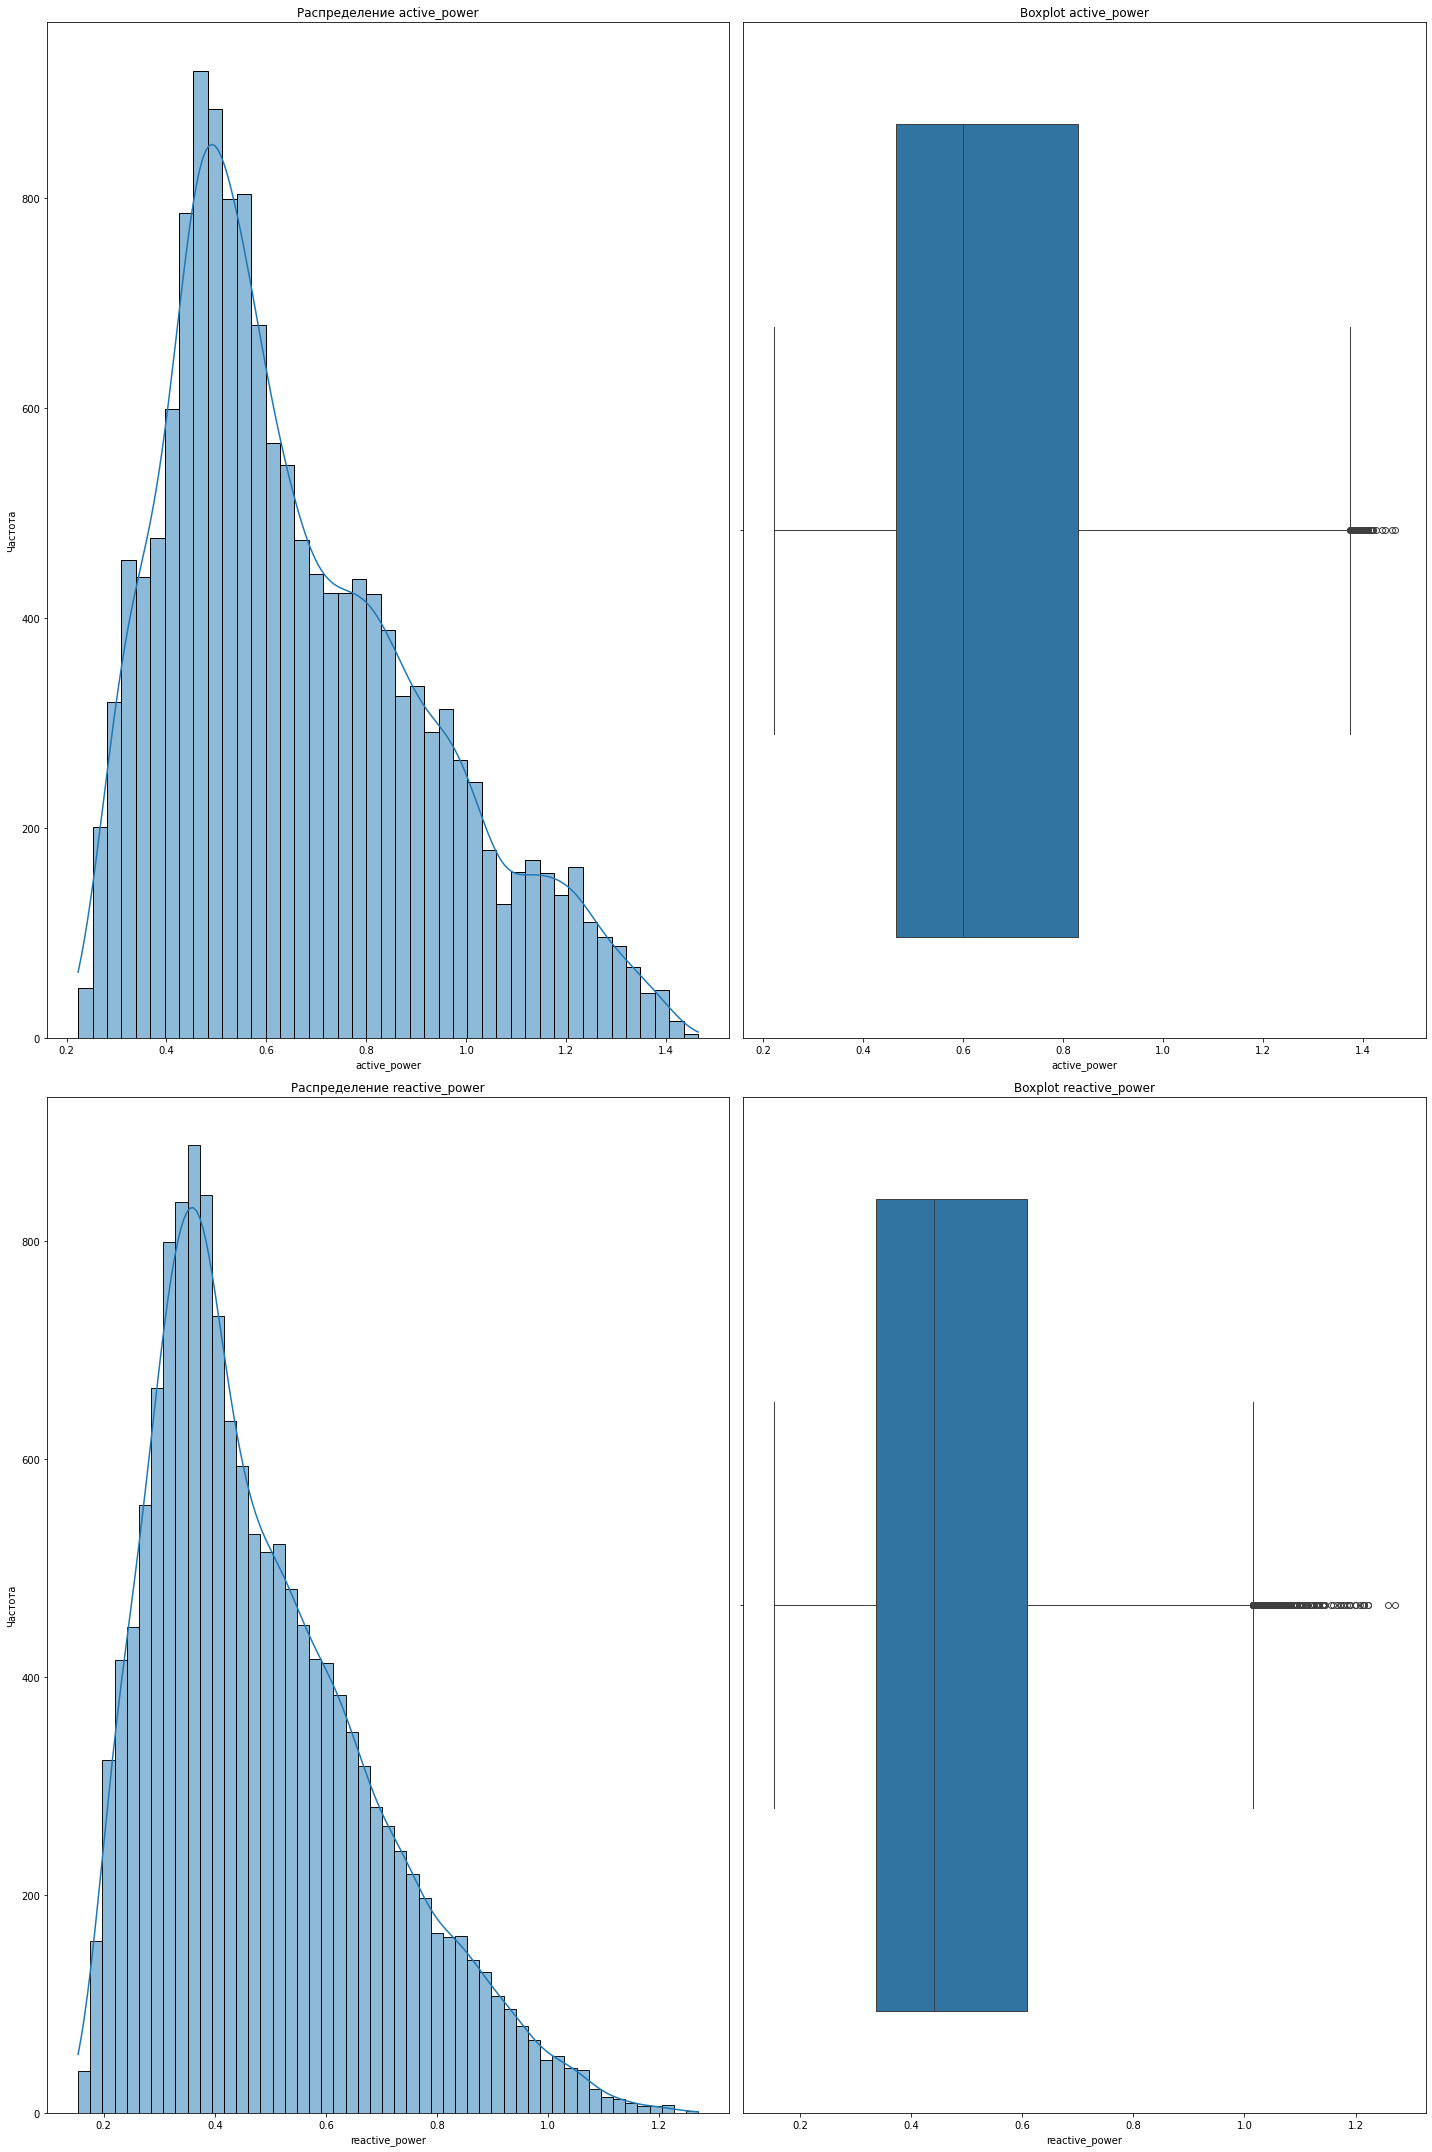

In [17]:
plot_distributions(data_arc, ['key', 'start_heating_arc', 'end_heating_arc'])

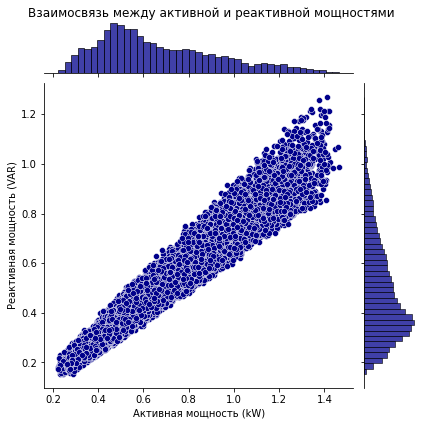

In [19]:
# Построение графика Зависимости 2 переменных
sns.jointplot(
    x=data_arc['active_power'], 
    y=data_arc['reactive_power'], 
    kind='scatter', 
    color='darkblue'
)

plt.suptitle('Взаимосвязь между активной и реактивной мощностями')
plt.xlabel('Активная мощность (kW)')
plt.ylabel('Реактивная мощность (VAR)')
plt.subplots_adjust(top=0.95)
plt.show()

**Вывод о распределении активной и реактивной мощности**

Распределение активной мощности (`active_power`):

1. **График рассеяния** показывает, что существует линейная зависимость между активной и реактивной мощностями. Большинство точек расположены вдоль наклонной линии, что свидетельствует о том, что при увеличении активной мощности возрастает и реактивная мощность.
2. **Ящик с усами (Boxplot)** для активной мощности указывает на наличие нескольких выбросов, которые находятся выше верхней границы усов. Это означает, что есть несколько значений активной мощности, которые значительно превышают типичные значения.
3. **Гистограмма** показывает, что распределение активной мощности имеет смещение вправо, с преобладанием значений в диапазоне от 0,4 до 0,8 кВт.

Распределение реактивной мощности (`reactive_power`):

1. **График рассеяния** также демонстрирует линейную зависимость между реактивной и активной мощностями, что логично, учитывая их взаимосвязь в контексте работы электрических систем.
2. **Ящик с усами (Boxplot)** для реактивной мощности указывает на наличие выбросов, но их количество меньше по сравнению с активной мощностью. Основная масса данных сосредоточена в диапазоне от 0,3 до 0,6 ВАР.
3. **Гистограмма** показывает, что распределение реактивной мощности также имеет смещение вправо, но в меньшей степени по сравнению с активной мощностью. Большинство значений находятся в диапазоне от 0,3 до 0,6 ВАР.

Выводы на основе статистической таблицы:

- **Средние значения** для активной и реактивной мощности составляют 0,6628 кВт и 0,4871 ВАР соответственно, что находится в пределах основной массы распределений.
- **Минимальные и максимальные значения** показывают, что разброс данных достаточно широк, особенно для активной мощности, где максимальное значение составляет 1,4638 кВт.
- **Стандартное отклонение** для активной мощности (0,2589 кВт) и реактивной мощности (0,1976 ВАР) указывает на умеренное рассеивание значений вокруг среднего, с несколькими экстремальными значениями, о чем свидетельствуют выбросы на графиках.

В целом, активная и реактивная мощности демонстрируют нормальные распределения с некоторым количеством выбросов. \
Взаимосвязь между ними прослеживается четко и логично в контексте работы электрических систем, где увеличение активной мощности обычно сопровождается увеличением реактивной мощности.


#### Генерация новых признаков

1. **Полная мощность (Apparent Power)**

**Полная мощность** (также известная как **аппаратная мощность**) \
в электрических цепях представляет собой векторную сумму активной и реактивной мощностей. \
Полная мощность обозначается как $S$ и измеряется в вольт-амперах (ВА).

Полная мощность рассчитывается по **Формуле:**

$$
S = \sqrt{P^2 + Q^2}
$$

где:
- $P$ — активная мощность, измеряемая в ваттах (W).
- $Q$ — реактивная мощность, измеряемая в вольт-амперах реактивных (VAR).

2. **Коэффициент мощности (Power Factor)**

**Коэффициент мощности** (Power Factor) — это косинус угла $\phi$, \
который характеризует фазовый сдвиг между векторами полной и активной мощности. \
Он показывает, какая часть полной мощности используется для выполнения полезной работы.

Коэффициент мощности рассчитывается **Формуле:**

$$
\text{Power Factor} = \cos(\phi) = \frac{P}{S}
$$

где:
- $P$ — активная мощность (W).
- $S$ — полная мощность (ВА).

**Связь между активной, реактивной и полной мощностями**

Активная мощность $P$ выполняет полезную работу, тогда как реактивная мощность $Q$ не выполняет полезной работы, \
но необходима для поддержания электрических и магнитных полей в цепи. \
Полная мощность $S$ представляет собой сумму этих двух компонент.

Величина коэффициента мощности может варьироваться от 0 до 1:
- Если коэффициент мощности близок к 1, это означает,\
 что почти вся мощность используется для выполнения полезной работы.
 
- Если коэффициент мощности близок к 0, это означает, что значительная часть мощности теряется на поддержание полей,\
 и эффективность системы низкая.

Коэффициент мощности является важным показателем эффективности электрической системы.\
Чем выше коэффициент мощности, тем лучше используется энергия. \
В идеале, система должна иметь коэффициент мощности, близкий к 1, что свидетельствует о минимальных потерях и высокой эффективности.

3. **Длительность нагрева (`heating_duration`)**

heating_duration показывает время, затраченное на нагрев стали в одном цикле. 

**Формула:**

$$
\text{heating\_duration} = \text{end\_heating\_arc} - \text{start\_heating\_arc}
$$

где:
- $\text{start\_heating\_arc}$ — начало нагрева.
- $\text{end\_heating\_arc}$ — окончание нагрева.


4. **Потребленная энергия (`energy_consumed`)**

energy_consumed оценивает количество энергии, затраченной на нагрев стали.\
В данном случае используется активная мощность, так как она представляет ту часть энергии,\
которая фактически используется для выполнения полезной работы — нагрева стали.

**Формула:**

$$
\text{energy\_consumed} = \text{active\_power} \times \text{heating\_duration}
$$

где:
- $\text{active\_power}$ — активная мощность (W).
- $\text{heating\_duration}$ — длительность нагрева (s).

5. **Изменение активной мощности (`power_diff`)** \
**Формула:**

$$
\text{power\_diff}_i = \text{active\_power}_i - \text{active\_power}_{i-1}
$$

где:
- $\text{active\_power}_i$ — активная мощность на текущем шаге,
- $\text{active\_power}_{i-1}$ — активная мощность на предыдущем шаге.

Этот признак помогает анализировать, как меняется активная мощность в процессе нагрева. \
Значительные изменения могут указывать на нестабильность процесса или на необходимость корректировки параметров нагрева.

6. **`heating_duration_diff` — Изменение длительности нагрева**
**Формула:**    

$$
\text{heating\_duration\_diff}_i = \text{heating\_duration}_i - \text{heating\_duration}_{i-1}
$$

где:
- $\text{heating\_duration}_i$ — длительность нагрева на текущем шаге,
- $\text{heating\_duration}_{i-1}$ — длительность нагрева на предыдущем шаге.

Этот признак показывает, как изменяется время, затраченное на нагрев на каждом этапе. \
Он может указывать на изменения в процессе, такие как увеличение или сокращение времени нагрева, \
что может влиять на качество конечного продукта.


7. **Размах (`range`) активной мощности**

Размах — это разница между максимальным и минимальным значением active_power для каждой партии. \
Он показывает абсолютное изменение мощности внутри партии.

**Формула:**

$$
\text{range} = \max(\text{active\_power}) - \min(\text{active\_power})
$$

где:
- $\text{range}$ — размах значений активной мощности для партии.
- $\max(\text{active\_power})$ — максимальное значение активной мощности в партии.
- $\min(\text{active\_power})$ — минимальное значение активной мощности в партии.


In [20]:
# 1 Рассчитываем полную мощность (аппаратную мощность)
data_arc['apparent_power'] = np.sqrt(data_arc['active_power']**2 + data_arc['reactive_power']**2)

# 2 Рассчитываем коэффициент мощности (cos(φ))
data_arc['power_factor'] = data_arc['active_power'] / data_arc['apparent_power']

# 3 Создаем новый признак "Длительность нагрева" в секундах
data_arc['heating_duration'] = (data_arc['end_heating_arc'] - data_arc['start_heating_arc']).dt.total_seconds()

# 4 Создаем новый признак energy_consumed
data_arc['energy_consumed'] = data_arc['apparent_power'] * data_arc['heating_duration']

# 5 6 Группируем данные по ключу 'key' и рассчитываем разницу длительности и энергии внутри каждой группы 
data_arc['power_diff'] = data_arc.groupby('key')['active_power'].diff()
data_arc['heating_duration_diff'] = data_arc.groupby('key')['heating_duration'].diff()

data_arc['power_diff'].fillna(0, inplace=True)
data_arc['heating_duration_diff'].fillna(0, inplace=True)

# 7 power_change + замена некорректных значений
data_arc['power_change'] = data_arc['power_diff'] / data_arc['heating_duration_diff']
data_arc['power_change'].replace([np.inf, -np.inf], 0, inplace=True)
data_arc['power_change'].fillna(0, inplace=True)

data_arc = data_arc.round(7) # округлим числа в таблице до 7го знака после запятой для экономии памяти

In [21]:
data_info(data_arc, 'Данные о дуговом нагреве ')


Таблица: Данные о дуговом нагреве 
Количество строк: 14876
Количество столбцов: 12
Первые 2 строки:


,key,start_heating_arc,end_heating_arc,active_power,reactive_power,apparent_power,power_factor,heating_duration,energy_consumed,power_diff,heating_duration_diff,power_change
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.3051,0.2113,0.3711,0.8222,228.0000,84.6160,0.0000,0.0000,0.0000
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.7657,0.4774,0.9023,0.8485,185.0000,166.9290,0.4605,-43.0000,-0.0107


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   key                    14876 non-null  Int64         
 1   start_heating_arc      14876 non-null  datetime64[ns]
 2   end_heating_arc        14876 non-null  datetime64[ns]
 3   active_power           14876 non-null  float64       
 4   reactive_power         14876 non-null  float64       
 5   apparent_power         14876 non-null  float64       
 6   power_factor           14876 non-null  float64       
 7   heating_duration       14876 non-null  float64       
 8   energy_consumed        14876 non-null  float64       
 9   power_diff             14876 non-null  float64       
 10  heating_duration_diff  14876 non-null  float64       
 11  power_change           14876 non-null  float64       
dtypes: Int64(1), datetime64[ns](2), float

,key,active_power,reactive_power,apparent_power,power_factor,heating_duration,energy_consumed,power_diff,heating_duration_diff,power_change
count,14876.0000,14876.0000,14876.0000,14876.0000,14876.0000,14876.0000,14876.0000,14876.0000,14876.0000,14876.0000
mean,1615.2204,0.6628,0.4871,0.8234,0.8059,171.6709,141.6439,0.0012,-7.4253,0.0002
std,934.5715,0.2589,0.1976,0.3235,0.0277,98.1868,103.1976,0.3236,125.0534,0.0389
min,1.0000,0.2231,0.1538,0.2757,0.7077,11.0000,6.4095,-1.1411,-632.0000,-1.0074
25%,806.0000,0.4671,0.3372,0.5788,0.7881,107.0000,71.1584,-0.1586,-69.0000,-0.0016
50%,1617.0000,0.5996,0.4417,0.7466,0.8097,147.0000,114.4626,0.0000,0.0000,0.0000
75%,2429.0000,0.8301,0.6082,1.0304,0.8270,214.0000,181.3457,0.1652,41.0000,0.0017
max,3241.0000,1.4638,1.2703,1.8982,0.8805,907.0000,1084.7294,1.1412,670.0000,0.9059


In [22]:
agg_arc = data_arc.groupby('key').agg({
  'key' :  [('cycles', 'count')],
  'start_heating_arc': [('min')],
  'end_heating_arc': [('max')],
  'active_power': ['mean', 
                     'max', 
                     'min', 
                     'std', 
                     lambda x: x.max() - x.min()],

  'reactive_power': ['mean'],

  'apparent_power': ['mean', 
                     'max', 
                     'min', 
                     'std', 
                     lambda x: x.max() - x.min()],

  'power_factor': ['mean'],

  'heating_duration': ['sum', 
                       'std'],

  'energy_consumed': ['sum', 
                      'std'], 

  'power_diff': ['mean'],

  'heating_duration_diff': ['mean'],

  'power_change': ['mean', 
                   'max',
                   'min'] })

agg_arc = agg_arc.round(8)


# Переименование столбцов в одну логику
agg_arc.columns = [
    '_'.join(col).replace('<lambda_0>', 'range') 
    if isinstance(col, tuple) else col.replace('<lambda_0>', 'range') 
    for col in agg_arc.columns
]

agg_arc.columns = [col.replace('<lambda_0>', 'range') for col in agg_arc.columns]
# agg_arc.loc[agg_arc['heating_duration_sum'] < 1700]
data_info(agg_arc.loc[agg_arc['heating_duration_sum'] < 1700], 'Агрегированные данные о подаче электричества')


Таблица: Агрегированные данные о подаче электричества
Количество строк: 3179
Количество столбцов: 24
Первые 2 строки:


,key_cycles,start_heating_arc_min,end_heating_arc_max,active_power_mean,active_power_max,active_power_min,active_power_std,active_power_range,reactive_power_mean,apparent_power_mean,apparent_power_max,apparent_power_min,apparent_power_std,apparent_power_range,power_factor_mean,heating_duration_sum,heating_duration_std,energy_consumed_sum,energy_consumed_std,power_diff_mean,heating_duration_diff_mean,power_change_mean,power_change_max,power_change_min
key,,,,,,,,,,,,,,,,,,,,,,,,
1,5,2019-05-03 11:02:14,2019-05-03 11:28:37,0.6073,0.8671,0.3051,0.2194,0.5620,0.4286,0.7437,1.0799,0.3711,0.2682,0.7088,0.8167,1098.0000,86.3151,770.2821,55.6778,0.1124,-16.0000,0.0003,0.0143,-0.0107
2,4,2019-05-03 11:34:14,2019-05-03 11:53:18,0.5349,0.7863,0.2617,0.2532,0.5247,0.3633,0.6471,0.9553,0.3327,0.3066,0.6226,0.8253,811.0000,97.5684,481.7600,58.4605,0.1013,18.2500,-0.0005,0.0009,-0.0021


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
Index: 3179 entries, 1 to 3241
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   key_cycles                  3179 non-null   Int64         
 1   start_heating_arc_min       3179 non-null   datetime64[ns]
 2   end_heating_arc_max         3179 non-null   datetime64[ns]
 3   active_power_mean           3179 non-null   float64       
 4   active_power_max            3179 non-null   float64       
 5   active_power_min            3179 non-null   float64       
 6   active_power_std            3140 non-null   float64       
 7   active_power_range          3179 non-null   float64       
 8   reactive_power_mean         3179 non-null   float64       
 9   apparent_power_mean         3179 non-null   float64       
 10  apparent_power_max          3179 non-null   float64       
 11  apparent_power_min          3179 non-n

,key_cycles,active_power_mean,active_power_max,active_power_min,active_power_std,active_power_range,reactive_power_mean,apparent_power_mean,apparent_power_max,apparent_power_min,apparent_power_std,apparent_power_range,power_factor_mean,heating_duration_sum,heating_duration_std,energy_consumed_sum,energy_consumed_std,power_diff_mean,heating_duration_diff_mean,power_change_mean,power_change_max,power_change_min
count,3179.0000,3179.0000,3179.0000,3179.0000,3140.0000,3179.0000,3179.0000,3179.0000,3179.0000,3179.0000,3140.0000,3179.0000,3179.0000,3179.0000,3140.0000,3179.0000,3140.0000,3179.0000,3179.0000,3179.0000,3179.0000,3179.0000
mean,4.5747,0.6613,0.9604,0.4208,0.2369,0.5397,0.4860,0.8216,1.1956,0.5217,0.2958,0.6739,0.8059,780.3397,85.5541,644.1049,86.5832,0.0016,-7.0014,0.0001,0.0176,-0.0168
std,1.5101,0.1287,0.2316,0.1188,0.1017,0.2475,0.0978,0.1605,0.2912,0.1474,0.1279,0.3107,0.0140,301.0510,44.6443,283.7993,53.6280,0.0908,25.2804,0.0177,0.0555,0.0564
min,1.0000,0.2677,0.2677,0.2231,0.0016,0.0000,0.1962,0.3319,0.3319,0.2757,0.0003,0.0000,0.7398,57.0000,0.7071,33.4302,0.2842,-0.4304,-154.3333,-0.2493,0.0000,-1.0074
25%,4.0000,0.5728,0.7956,0.3318,0.1630,0.3569,0.4172,0.7109,0.9887,0.4128,0.2029,0.4461,0.7972,569.0000,53.9288,443.0841,50.0812,-0.0489,-16.5000,-0.0020,0.0011,-0.0114
50%,4.0000,0.6526,0.9648,0.4067,0.2327,0.5426,0.4813,0.8124,1.1981,0.5037,0.2919,0.6702,0.8064,765.0000,79.1088,616.8335,75.8020,0.0016,-7.6667,0.0001,0.0042,-0.0040
75%,5.5000,0.7400,1.1468,0.4798,0.3077,0.7244,0.5437,0.9173,1.4242,0.5954,0.3816,0.9049,0.8156,975.0000,107.3441,821.8032,111.3797,0.0522,2.3875,0.0024,0.0122,-0.0009
max,14.0000,1.2439,1.4638,1.1407,0.6087,1.1412,0.9608,1.5722,1.8982,1.4291,0.8144,1.4918,0.8570,1689.0000,339.8294,2181.9375,492.2716,0.3737,219.0000,0.2015,0.9059,0.0000


#### **Вывод по исследовательскому анализу данных об электродах**

- Количество циклов (`cycles`): Позволяет оценить количество нагревательных циклов для каждой партии​⬤
- Аппаратная мощность (`apparent_power`): Значительное рассеивание значений, указывающее на вариативность нагрузок системы.
- Коэффициент мощности (`power_factor`): Высокий уровень, свидетельствующий об эффективном использовании мощности.
- Длительность нагрева (`heating_duration`): Время нагрева варьируется, что влияет на стабильность процесса.
- Потребленная энергия (`energy_consumed`): Значительные колебания в энергопотреблении, указывающие на возможные неэффективности.
- Изменение мощности (`power_diff` и `power_change`): Анализ изменений мощности показывает важность стабильности процесса.
- Диапазон мощности (`power_range`): Варьирование мощностей требует внимания к пиковым нагрузкам и стабильности системы.

Процесс нагрева требует дальнейшего анализа и оптимизации для повышения стабильности и энергоэффективности.

**Агрегация таблицы**

В результате агрегации данных по партиям (`key`), мы получили сводную информацию по ключевым параметрам каждого производственного цикла:

- Количество циклов (`cycles`): Позволяет оценить количество нагревательных циклов для каждой партии.
- Средняя, максимальная и минимальная активная мощность (`active_power_mean`, `active_power_max`, `active_power_min`): Дают представление о типичных и крайних значениях мощности в процессе.
- Диапазон изменения активной и полной мощности (`active_power_range`, `apparent_power_range`): Помогает оценить амплитуду колебаний мощности, что важно для анализа стабильности процесса.
- Суммарное энергопотребление (`energy_consumed_sum`): Отражает общее количество энергии, затраченной на процесс для каждой партии.
- Среднее изменение мощности и продолжительности нагрева (`power_diff_mean`, `heating_duration_diff_mean`): Дают информацию о динамике изменений в процессе.

Агрегированные данные позволяют сделать выводы о стабильности и эффективности процессов нагрева, выявить возможные аномалии и области для оптимизации.


* В информации о некоторых партиях остались пропуски и выбросы, \
пока не будем избавляться от этих данных.
* Обработаем эти значения после финальной склейки таблиц,\
чтобы вести подсчет потереняного кол-ва данных.

### Таблицы `data_bulk` и `data_wire`

In [31]:
# для начала взгляним на таблицу data_bulk
data_info(data_bulk.drop('key', axis=1), 'Данные о примесях')
plot_distributions(data_bulk, exclude_columns=['key', 'bulk_8'])


Таблица: Данные о примесях
Количество строк: 3129
Количество столбцов: 15
Первые 2 строки:


,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,NaN,NaN,NaN,43.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0000,NaN,150.0000,154.0000
1,NaN,NaN,NaN,73.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0000,NaN,149.0000,154.0000


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   bulk_1   252 non-null    float64
 1   bulk_2   22 non-null     float64
 2   bulk_3   1298 non-null   float64
 3   bulk_4   1014 non-null   float64
 4   bulk_5   77 non-null     float64
 5   bulk_6   576 non-null    float64
 6   bulk_7   25 non-null     float64
 7   bulk_8   1 non-null      float64
 8   bulk_9   19 non-null     float64
 9   bulk_10  176 non-null    float64
 10  bulk_11  177 non-null    float64
 11  bulk_12  2450 non-null   float64
 12  bulk_13  18 non-null     float64
 13  bulk_14  2806 non-null   float64
 14  bulk_15  2248 non-null   float64
dtypes: float64(15)
memory usage: 366.8 KB


,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,252.0000,22.0000,1298.0000,1014.0000,77.0000,576.0000,25.0000,1.0000,19.0000,176.0000,177.0000,2450.0000,18.0000,2806.0000,2248.0000
mean,39.2421,253.0455,113.8790,104.3945,107.0260,118.9253,305.6000,49.0000,76.3158,83.2841,76.8192,260.4710,181.1111,170.2847,160.5133
std,18.2777,21.1806,75.4835,48.1841,81.7906,72.0578,191.0229,NaN,21.7206,26.0603,59.6554,120.6493,46.0880,65.8687,51.7653
min,10.0000,228.0000,6.0000,12.0000,11.0000,17.0000,47.0000,49.0000,63.0000,24.0000,8.0000,53.0000,151.0000,16.0000,1.0000
25%,27.0000,242.0000,58.0000,72.0000,70.0000,69.7500,155.0000,49.0000,66.0000,64.0000,25.0000,204.0000,153.2500,119.0000,105.0000
50%,31.0000,251.5000,97.5000,102.0000,86.0000,100.0000,298.0000,49.0000,68.0000,86.5000,64.0000,208.0000,155.5000,151.0000,160.0000
75%,46.0000,257.7500,152.0000,133.0000,132.0000,157.0000,406.0000,49.0000,70.5000,102.0000,106.0000,316.0000,203.5000,205.7500,205.0000
max,185.0000,325.0000,454.0000,281.0000,603.0000,503.0000,772.0000,49.0000,147.0000,159.0000,313.0000,1849.0000,305.0000,636.0000,405.0000


**Выводы:**

- Неполнота данных: 

  - В таблице присутствуют значительные пропуски данных для некоторых переменных.\
  Например, столбцы `bulk_2`, `bulk_7`, `bulk_9`, `bulk_13` содержат крайне малое количество ненулевых значений, что может свидетельствовать о редком использовании этих материалов.
  - В дальнейшем пропуски будут заполнены 0, так как отсутсвие данных по какому либо материалу означает, что материал просто не использовался в партии.

- Распределение значений:
  - Большинство столбцов (например, `bulk_3`, `bulk_4`, `bulk_12`, `bulk_14`) имеют распределения, близкие к нормальному с умеренным смещением.

  - Столбцы `bulk_1`, `bulk_6`, и `bulk_10` демонстрируют более выраженное правостороннее смещение, что указывает на то, что большая часть значений находится в нижней части диапазона, а верхние значения встречаются редко.

- Варьирование значений:
  - Столбцы, такие как `bulk_5`, `bulk_6`, и `bulk_14`, имеют значительный разброс данных (высокое стандартное отклонение), что говорит о разнообразии используемых количеств материалов в этих категориях.

  - Для некоторых столбцов наблюдаются экстремальные значения (выбросы), например, `bulk_5` и `bulk_13`, что может указывать на аномалии в данных или на отдельные партии с уникальными условиями.

- Концентрация данных:
  - В таких столбцах, как `bulk_12` и `bulk_14`, наблюдается высокая концентрация данных в узком диапазоне значений, что может свидетельствовать о стандартизированном использовании этих материалов.
  - Столбец `bulk_3` показывает более равномерное распределение, что может говорить о более разнообразных условиях использования данного материала.

- Малое количество данных: 
    - В некоторых столбцах, таких как `bulk_2`, `bulk_6` и `bulk_13`, данные присутствуют в минимальных количествах, что затрудняет их анализ и требует осторожного подхода при интерпретации результатов.


Таблица: Данные о проволоках
Количество строк: 3081
Количество столбцов: 9
Первые 2 строки:


,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,60.0600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,96.0523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wire_1  3055 non-null   float64
 1   wire_2  1079 non-null   float64
 2   wire_3  63 non-null     float64
 3   wire_4  14 non-null     float64
 4   wire_5  1 non-null      float64
 5   wire_6  73 non-null     float64
 6   wire_7  11 non-null     float64
 7   wire_8  19 non-null     float64
 8   wire_9  29 non-null     float64
dtypes: float64(9)
memory usage: 216.8 KB


,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3055.0000,1079.0000,63.0000,14.0000,1.0000,73.0000,11.0000,19.0000,29.0000
mean,100.8959,50.5773,189.4827,57.4428,15.1320,48.0170,10.0390,53.6252,34.1558
std,42.0125,39.3202,99.5134,28.8247,NaN,33.9198,8.6106,16.8817,19.9316
min,1.9188,0.0302,0.1441,24.1488,15.1320,0.0343,0.2342,45.0767,4.6228
25%,72.1157,20.1937,95.1350,40.8070,15.1320,25.0536,6.7628,46.0949,22.0584
50%,100.1582,40.1430,235.1950,45.2343,15.1320,42.0763,9.0170,46.2800,30.0664
75%,126.0605,70.2276,276.2520,76.1246,15.1320,64.2127,11.8861,48.0896,43.8620
max,330.3144,282.7802,385.0087,113.2310,15.1320,180.4546,32.8477,102.7624,90.0536


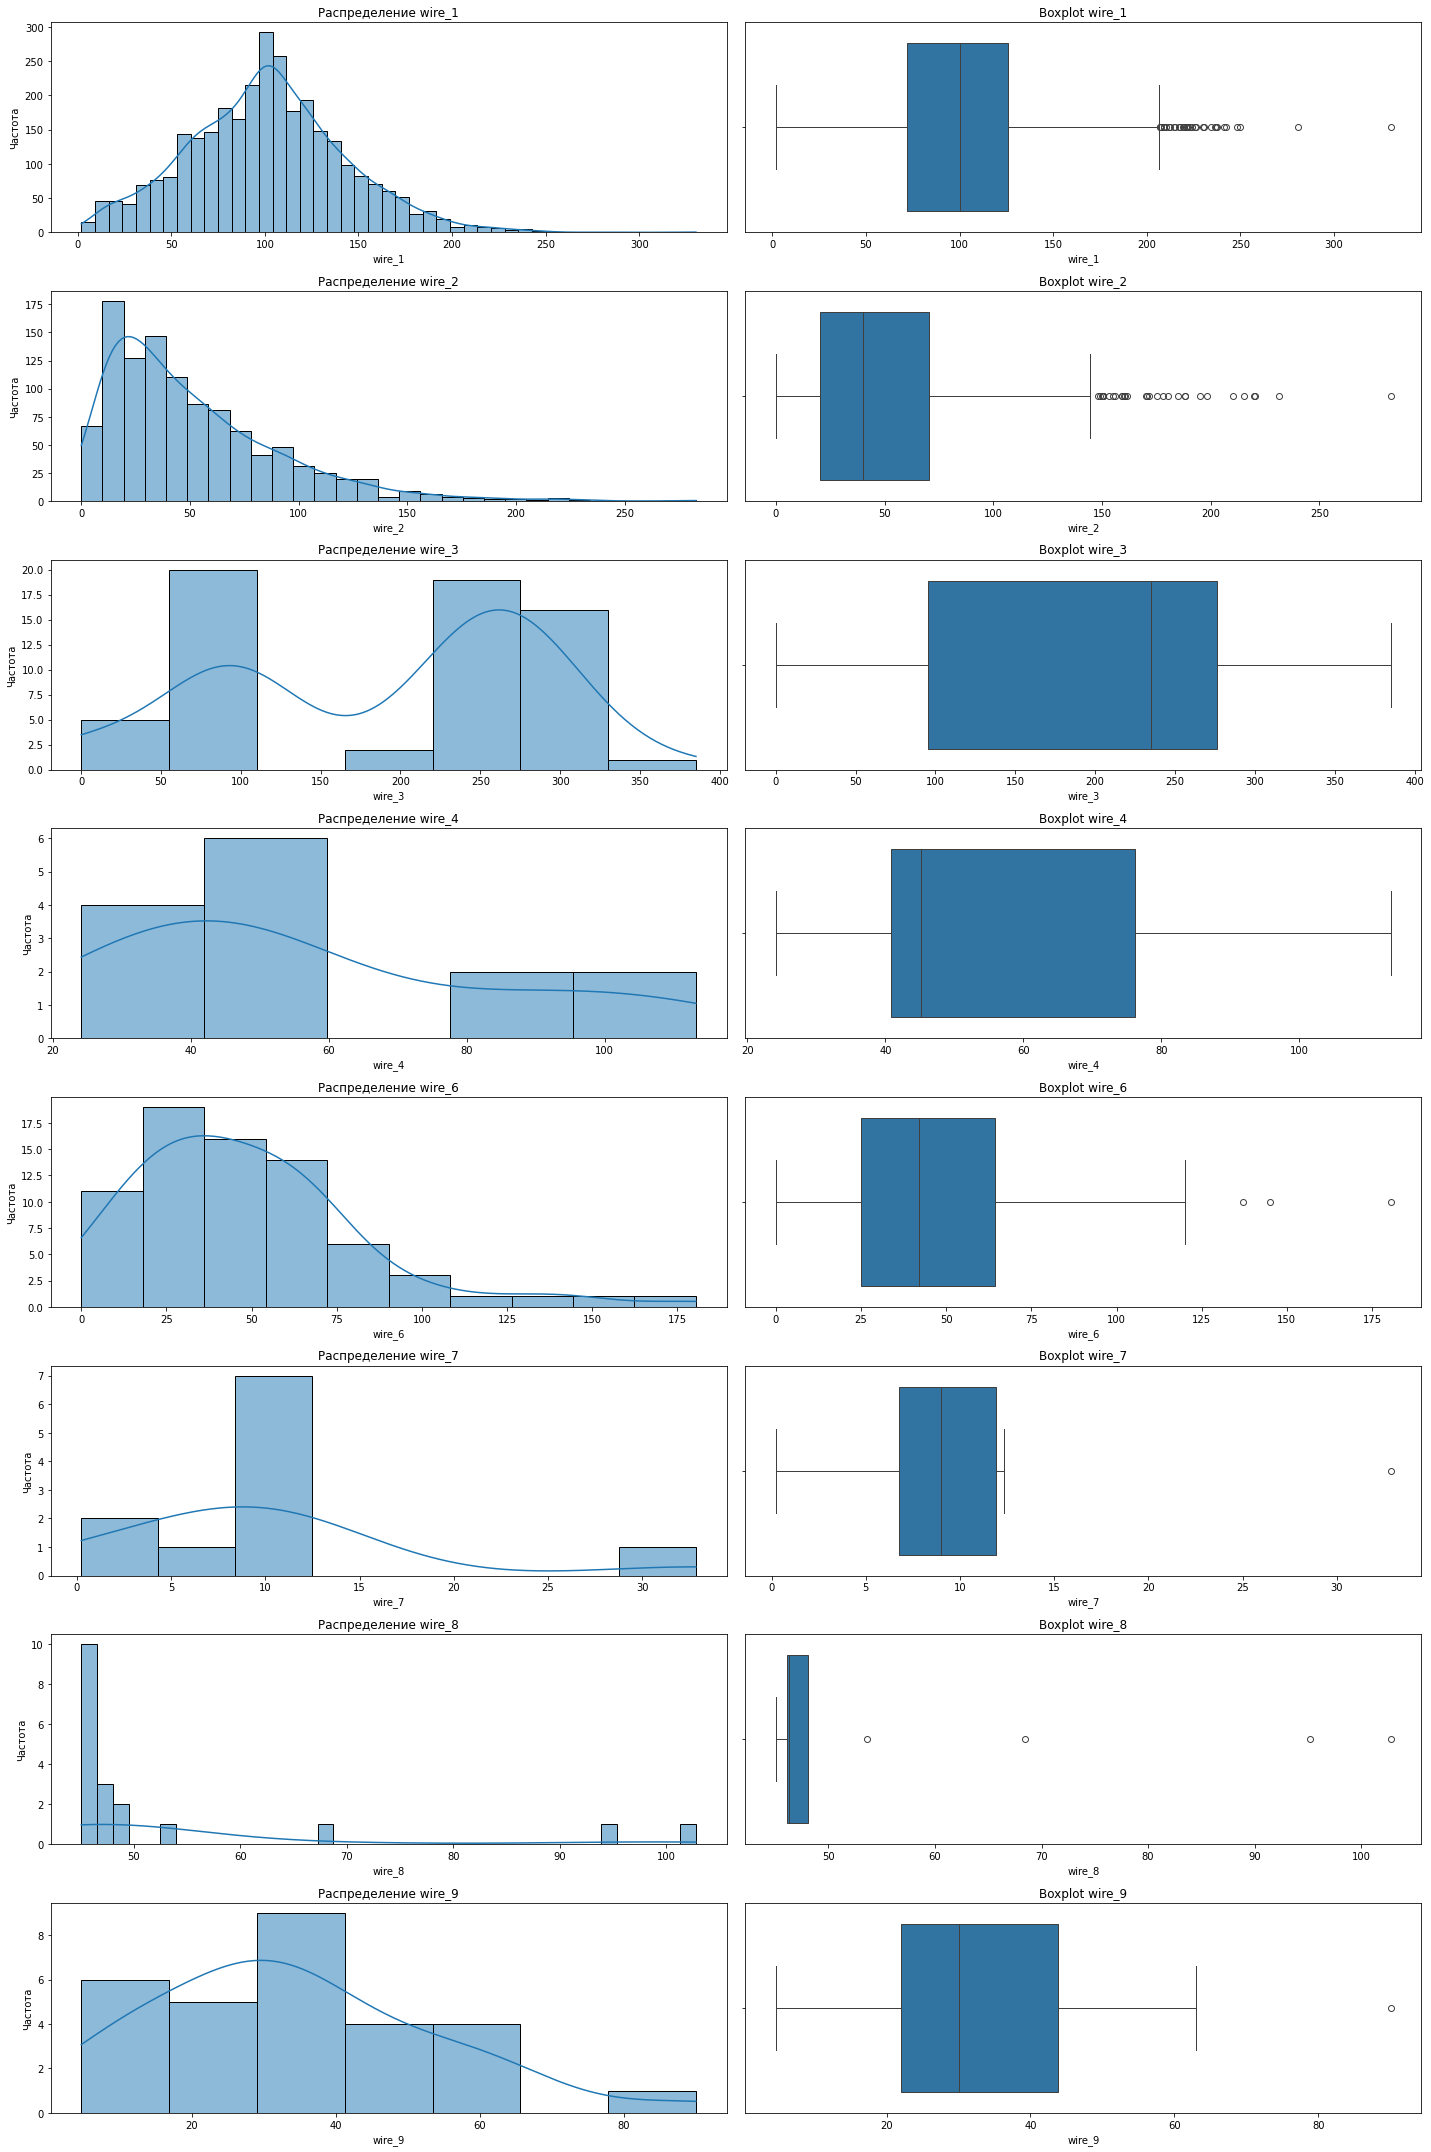

In [34]:
# Теперь посмотрим на данные таблицы data_wire 
data_info(data_wire.drop('key', axis=1), 'Данные о проволочных материалах')
plot_distributions(data_wire, exclude_columns=['wire_5','key'])

**Вывод о числовых распределениях в таблице проволочных материалов:**

- Неполнота данных: 
    - Как и в предыдущей таблице, в большинстве столбцов наблюдается значительное количество пропусков, особенно в столбцах `wire_3`, `wire_4`, `wire_5`, `wire_6`, `wire_7`, `wire_8`, и `wire_9`. \
    Столбец `wire_5` содержит только одно значение, что делает его нерелевантным для анализа.

- Распределение значений:
  - `wire_1` и `wire_2` имеют относительно нормальные распределения с правосторонним смещением, что указывает на более частое использование меньших объемов этих материалов.
  - Для других столбцов, таких как `wire_3`, `wire_4`, и `wire_6`, наблюдаются более хаотичные распределения с несколькими пиками, что может свидетельствовать о нерегулярности использования этих материалов.

- Варьирование значений:
  - Столбцы `wire_1` и `wire_3` показывают значительное варьирование данных (высокое стандартное отклонение), что указывает на разнообразие в количестве используемых проволочных материалов в этих категориях.
  - Столбцы `wire_4` и `wire_7` имеют меньший разброс данных, что говорит о более стандартизированном использовании этих материалов.

- Выбросы: 
    - В некоторых столбцах, таких как `wire_1`, `wire_2`, и `wire_6`, на графиках Boxplot видно наличие выбросов, что может указывать на отдельные партии с необычно высокими объемами используемых материалов.

- Концентрация данных:
  - Столбцы `wire_1` и `wire_2` имеют значительную концентрацию данных в нижних диапазонах, что свидетельствует о частом использовании небольших объемов этих материалов.
  - В столбцах `wire_7`, `wire_8`, и `wire_9` данные сконцентрированы в узком диапазоне, что говорит о редком, но стандартизированном использовании этих материалов.

Распределение данных по столбцам указывает на значительное варьирование в количестве используемых проволочных материалов. \
Необходим дальнейший анализ для понимания причин высокой вариативности и выявления возможных аномалий в данных. \
Также стоит рассмотреть возможность исключения столбцов с крайне малым количеством данных из анализа.

#### Склейка таблиц, создание нового признака.

Поскольку 2 таблицы имеют достаточно схожую структуру,\
создадим общую таблицу, которая будет содержать общую информацию о всех используемых примесях.

In [39]:
# Склейка таблиц по ключу 'key'
data_addons = pd.merge(data_bulk, data_wire, on='key', suffixes=('_bulk', '_wire'))

# Создание столбцов для суммы значений в таблицах data_bulk и data_wire
data_addons['bulk_sum'] = data_addons.filter(like='bulk_').sum(axis=1)
data_addons['wire_sum'] = data_addons.filter(like='wire_').sum(axis=1)

# Создание столбца, который суммирует значения bulk_sum и wire_sum
data_addons['added_sum'] = data_addons['bulk_sum'] + data_addons['wire_sum']



Таблица: Данные о проволочных материалах
Количество строк: 3025
Количество столбцов: 3
Первые 2 строки:


,bulk_sum,wire_sum,added_sum
0,553.0000,60.0600,613.0600
1,582.0000,96.0523,678.0523


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3025 entries, 0 to 3024
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bulk_sum   3025 non-null   float64
 1   wire_sum   3025 non-null   float64
 2   added_sum  3025 non-null   float64
dtypes: float64(3)
memory usage: 71.0 KB


,bulk_sum,wire_sum,added_sum
count,3025.0000,3025.0000,3025.0000
mean,602.3626,123.8331,726.1957
std,276.4671,65.8497,285.0360
min,19.0000,1.9188,54.0622
25%,440.0000,86.4864,557.9950
50%,597.0000,114.1920,722.2317
75%,779.0000,150.1812,916.6850
max,3235.0000,663.8518,3423.2285


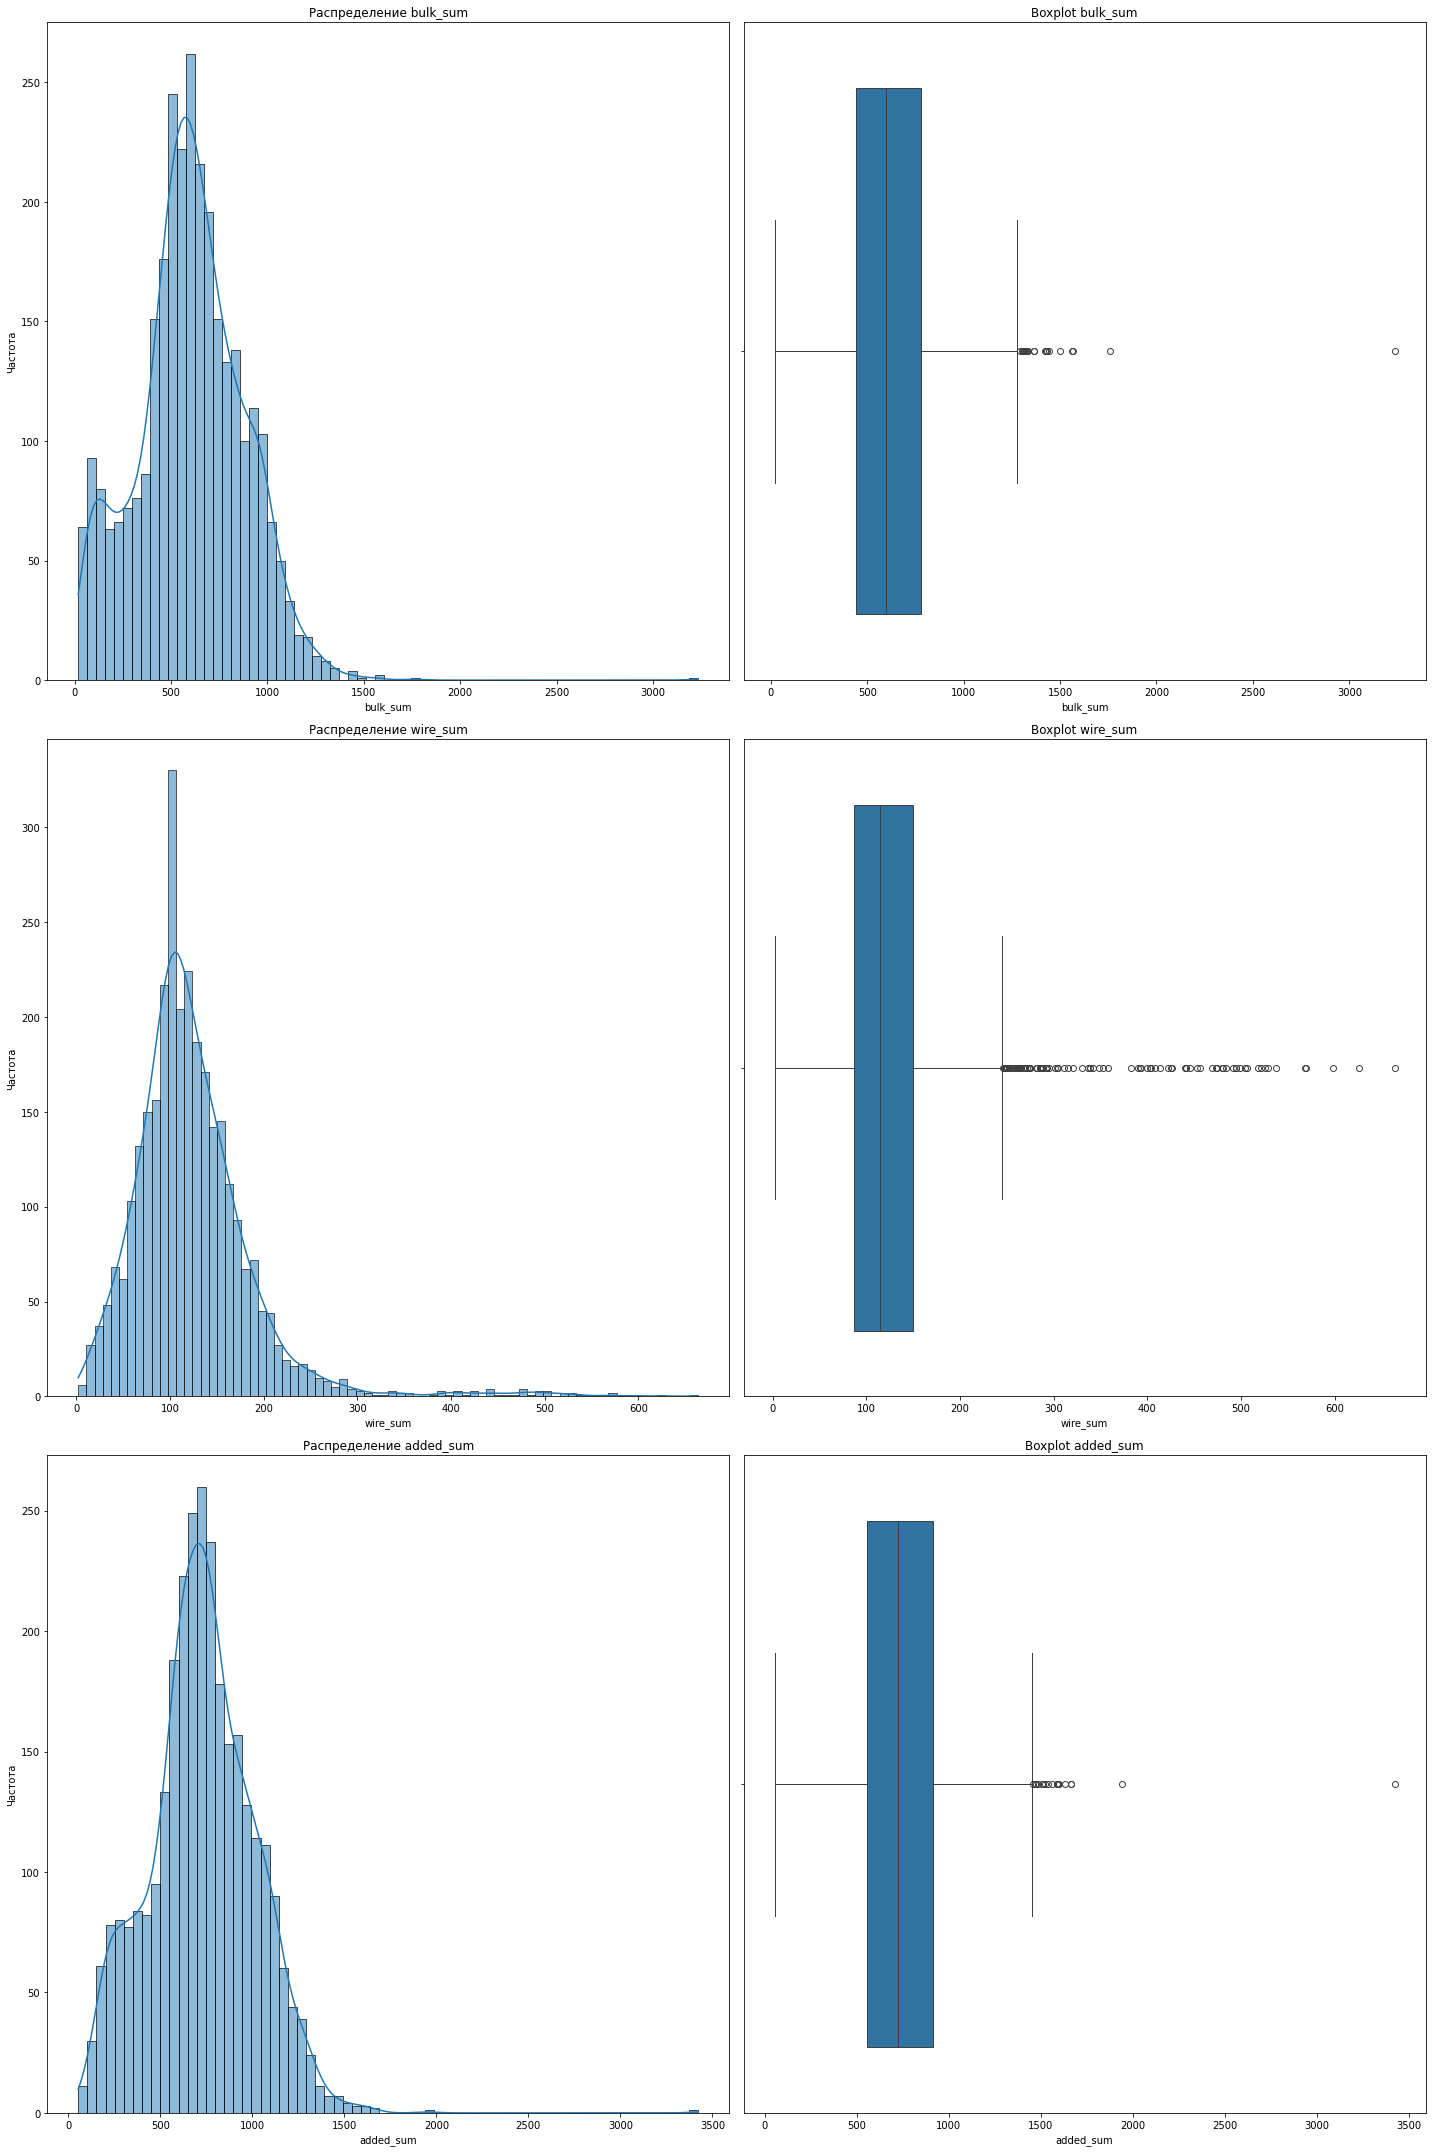

In [43]:
# Просмотр результата
agg_arc.loc[agg_arc['heating_duration_sum'] < 1700]
data_info(data_addons[['bulk_sum', 'wire_sum', 'added_sum']], 'Данные о проволочных материалах')
plot_distributions(data_addons[['bulk_sum', 'wire_sum', 'added_sum']])

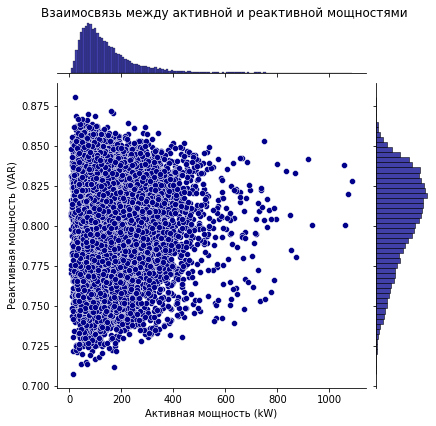

In [27]:
sns.jointplot(
    x=data_arc['energy_consumed'], 
    y=data_arc['power_factor'], 
    kind='scatter', 
    color='darkblue'
)

plt.suptitle('Взаимосвязь между активной и реактивной мощностями')
plt.xlabel('Активная мощность (kW)')
plt.ylabel('Реактивная мощность (VAR)')
plt.subplots_adjust(top=0.95)
plt.show()